In [12]:
%load_ext autoreload
%autoreload 2
%pylab inline
from functools import partial, reduce
from funcy import compose
import numpy as np
from parametric_pde_find import *
from scipy.integrate import odeint
from scipy.stats import wilcoxon, ttest_rel
from scipy.signal import savgol_filter
from numpy.fft import fft, ifft, fftfreq
from robust_pde_diff import DLrSR, RobustPCA, DLrSR_para
from para_UBIC import *
from best_subset import *
from solvel0 import solvel0

from findiff import FinDiff
from abess.linear import LinearRegression
from sklearn.linear_model import BayesianRidge, ARDRegression, Ridge, Lasso
from UBIC import fit_blr, UBIC, decreasing_values_indices
from skscope_tools import best_subset_all_solutions, abess_all_solutions
# https://github.com/Pongpisit-Thanasutives/OKRidge
from okridge.solvel0 import okridge_solvel0, okridge_solvel0_full

import sys; sys.path.append('/Users/pongpisit/Documents/github/ICOMP/')
from icomp_lm import *

from tqdm import tqdm

fontsize = 20 # for plots

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
def ks_rhs(u, t, params):
    k, L, x = params
    a = (1 + 0.25*np.sin(x*2*np.pi/L))  # uu_x
    b = -1 + 0.25*np.exp(-(x-2)**2/5)   # u_{xx}
    c = -1 - 0.25*np.exp(-(x+2)**2/5)   # u_{xxxx}
    deriv = a*u*ifft(1j*k*fft(u)) + b*ifft(-k**2*fft(u)) + c*ifft(k**4*fft(u))
    return real(deriv)

In [3]:
# Set size of grid
n = 512
m = 512
L = 20
max_time = 200

# Set up grid
x = np.linspace(-L,L,n+1)[:-1]; dx = x[1]-x[0]
t = np.linspace(0,max_time,2*m); dt = t[1]-t[0]
k = 2*np.pi*fftfreq(n, d = dx)

# Initial condition
u0 = np.exp(-(x)**2)

# Solve with time dependent uu_x term
params = (k,L,x)
# u_full = odeint(ks_rhs, u0, t, args=(params,)).T
u_full = np.load("./Datasets/ks_u_full.npy")

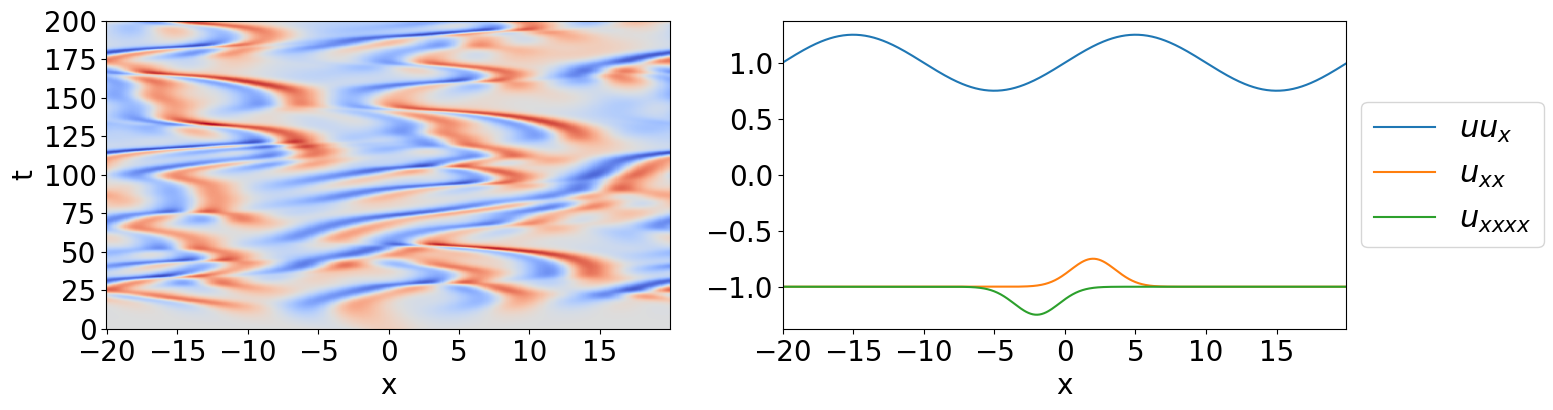

In [4]:
# Plot
fig = figure(figsize=(16, 4))
X, T = np.meshgrid(x, t)

subplot(1,2,1)
pcolor(X, T, u_full.T, cmap=cm.coolwarm)
xlabel('x', fontsize = fontsize)
ylabel('t', fontsize = fontsize)
xticks(fontsize = fontsize)
yticks(fontsize = fontsize)

uu_x_true = 1 + 0.25*np.sin(x*2*np.pi/L)
u_xx_true = -1 + 0.25*np.exp(-(x-2)**2/5)
u_4x_true = -1 - 0.25*np.exp(-(x+2)**2/5)

subplot(1,2,2)
plot(x, uu_x_true, label = r'$uu_x$')
plot(x, u_xx_true, label = r'$u_{xx}$')
plot(x, u_4x_true, label = r'$u_{xxxx}$')
xlim([x[0],x[-1]])

xticks(fontsize = fontsize)
yticks(fontsize = fontsize)
xlabel('x', fontsize = fontsize)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = fontsize+2)
# fig.tight_layout()

In [5]:
# u = u_full[:,-m:]
# t = t[-m:]
u = u_full[:,:m]
t = t[:m]

In [6]:
noise_lv = 0.01
np.random.seed(0)
u = u + noise_lv*0.01*std(u)*np.random.randn(n,m)

is_denoising = True
if is_denoising and noise_lv > 0:
    window_size = 15
    poly_order = 2
    u = savgol_filter(u, window_size, poly_order, axis=0)

alpha = 3e-4
diff_kwargs = {"kind": "kalman", "alpha": alpha}
Ut, Theta, Ut_grouped, Theta_grouped, rhs_des = construct_group_linear_system(u, x, t, 
                                                                              diff_kwargs, 
                                                                              include_bias=False)

In [7]:
# Theta_grouped = np.array([real(Theta[n*np.arange(m)+j,:]) for j in range(n)])
# Ut_grouped = np.array([real(Ut[n*np.arange(m)+j]) for j in range(n)])
fft_percent = 90
fft_Theta_grouped = np.array([remove_f(fft(Theta_grouped[:, :, k]), fft_percent) 
                              for k in range(Theta_grouped.shape[-1])])
fft_Theta_grouped = np.moveaxis(fft_Theta_grouped, 0, -1)
fft_Ut_grouped = remove_f(fft(Ut_grouped[:, :, 0]), fft_percent)
fft_Ut_grouped = np.expand_dims(fft_Ut_grouped, -1)

In [8]:
# Solve and plot
Xi,Tol,Losses = TrainSGTRidge(Theta_grouped, Ut_grouped)
xi = Xi[np.argmin(Losses)]

4 u_xx
5 u_xxx
6 u_xxxx
7 uu_x


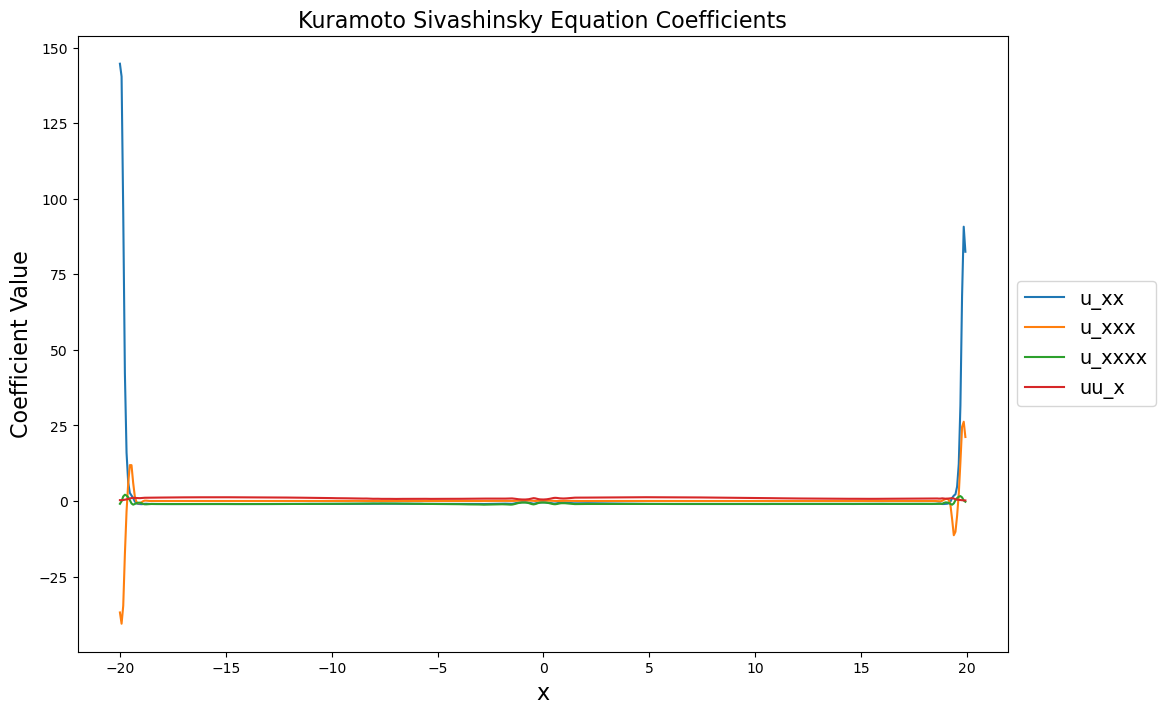

In [9]:
pylab.rcParams['figure.figsize'] = (12, 8)
for j in range(xi.shape[0]): 
    if np.linalg.norm(xi[j,:]) > 10**-10:
        print(j, rhs_des[j])
        plot(x, xi[j,:], label = rhs_des[j])
                
title('Kuramoto Sivashinsky Equation Coefficients', fontsize = 16)
xlabel('x', fontsize = 16)
ylabel('Coefficient Value', fontsize = 16)
legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize = 14)
plt.show()
# mse_clean_sgtr = Norm(xi-xi_true[:,wx:-wx])**2/(m*len(rhs_des))
# print('MSE: ', mse_clean_sgtr)

In [10]:
max_complexity = 10
candidates = [[] for _ in range(max_complexity)]
for i in trange(len(Theta_grouped)):
    candidates_i = sorted(set(solvel0(Theta_grouped[i], Ut_grouped[i], max_complexity=max_complexity, 
                                      miosr=True, refine=True, verbose=False)), key=len)
    for i in range(max_complexity):
        candidates[i].append(candidates_i[i])
candidates   

  0%|                                                                                                  | 0/512 [00:00<?, ?it/s]

Set parameter Username
Academic license - for non-commercial use only - expires 2024-06-04


100%|████████████████████████████████████████████████████████████████████████████████████████| 512/512 [05:12<00:00,  1.64it/s]


[[(3,),
  (3,),
  (3,),
  (3,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (11,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (15,),
  (15,),
  (15,),
  (15,),
  (15,),
  (7,),
  (7,),
  (7,),
  (7,),
  (17,),
  (17,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (7,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (3,),
  (7,),
  (7

3 1 1


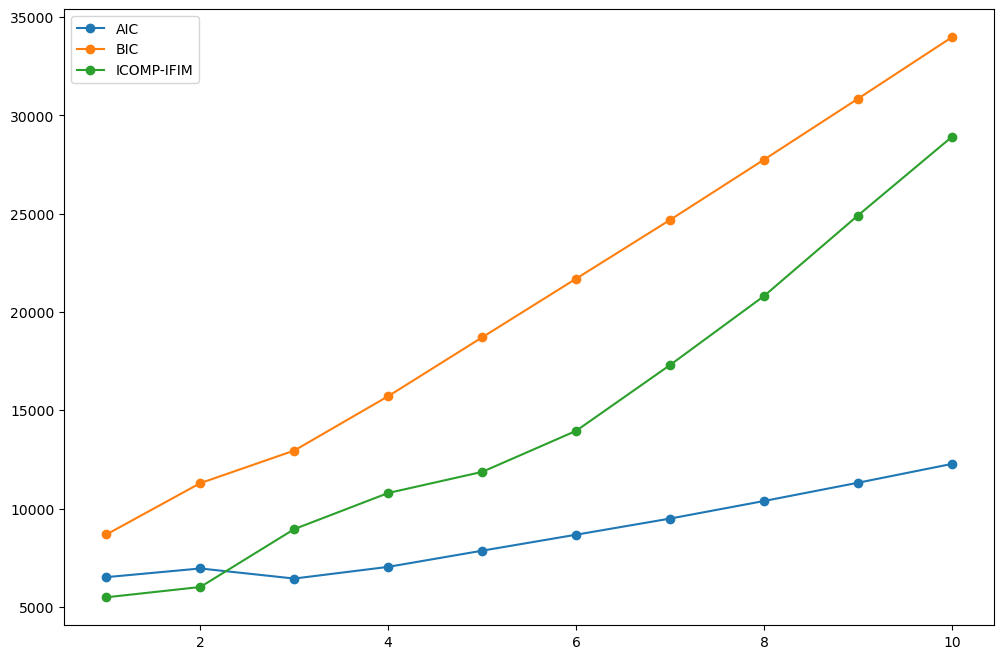

In [19]:
# from scipy import linalg as splinalg
# from scipy.sparse import csc_array, csc_matrix
# from scipy.sparse import linalg as splin

# for indices in sorted(candidates, key=len):
#     theta_b = csc_matrix(splinalg.block_diag(*[Theta_grouped[j][:, indices] for j in range(len(Theta_grouped))]), dtype=float)
#     ut_b = Ut_grouped.reshape(-1, 1)
#     xi_b = splin.lsqr(theta_b, ut_b)[0].reshape(-1, 1)
#     rss = np.sum((ut_b-theta_b@xi_b)**2)
#     print(len(indices), rss2bic(rss, np.count_nonzero(xi_b), len(ut_b)))
#     break

time_integrator = lambda _: _
time_integrator = partial(trapz, axis=1)
time_integrator = compose(time_integrator, 
                          lambda _ : periodogram(_, return_onesided=False, axis=1)[1])
epsilon = 0
ic_scores = {}
ICOMPs = []
AICs = []
BICs = []
for candidate in candidates:
    CMs = []
    k = 0
    est_xi = np.zeros((Theta_grouped[0].shape[-1], len(Ut_grouped)))
    for j in range(len(Theta_grouped)):
        est_xi[candidate[j], j:j+1] = np.linalg.lstsq(Theta_grouped[j][:, candidate[j]], Ut_grouped[j], rcond=None)[0]
        _, CM, _ = llf_complexity(Theta_grouped[j][:, candidate[j]], Ut_grouped[j], a_n=np.log(len(Ut_grouped[j])))
        CMs.append(CM[0])
        k += len(candidate[j])

    Ut_grouped_est = estimate_Ut_grouped_est(Theta_grouped, est_xi)
    rss = rss_group(Ut_grouped_est, Ut_grouped, time_integrator)
    # N = np.prod(Ut_grouped.shape)
    N = np.prod(time_integrator(Ut_grouped).shape)
    
    # aic = PDE_FIND_Loss(Theta_grouped, Ut_grouped, est_xi)
    # bic = BIC_Loss(Theta_grouped, Ut_grouped, est_xi)
    aic = N*np.log(2*np.pi*rss/N+epsilon) + 2*k
    bic = N*np.log(2*np.pi*rss/N+epsilon) + np.log(N)*k
    icomp = N*np.log(2*np.pi*rss/N+epsilon) + np.log(N)*np.sum(CMs)
    AICs.append(aic)
    BICs.append(bic)
    ICOMPs.append(icomp)

print(np.argmin(AICs)+1, np.argmin(BICs)+1, np.argmin(ICOMPs)+1)
plt.plot([_+1 for _ in range(max_complexity)], AICs, '-o', label='AIC')
plt.plot([_+1 for _ in range(max_complexity)], BICs, '-o', label='BIC')
plt.plot([_+1 for _ in range(max_complexity)], ICOMPs, '-o', label='ICOMP')
plt.legend()
plt.show()

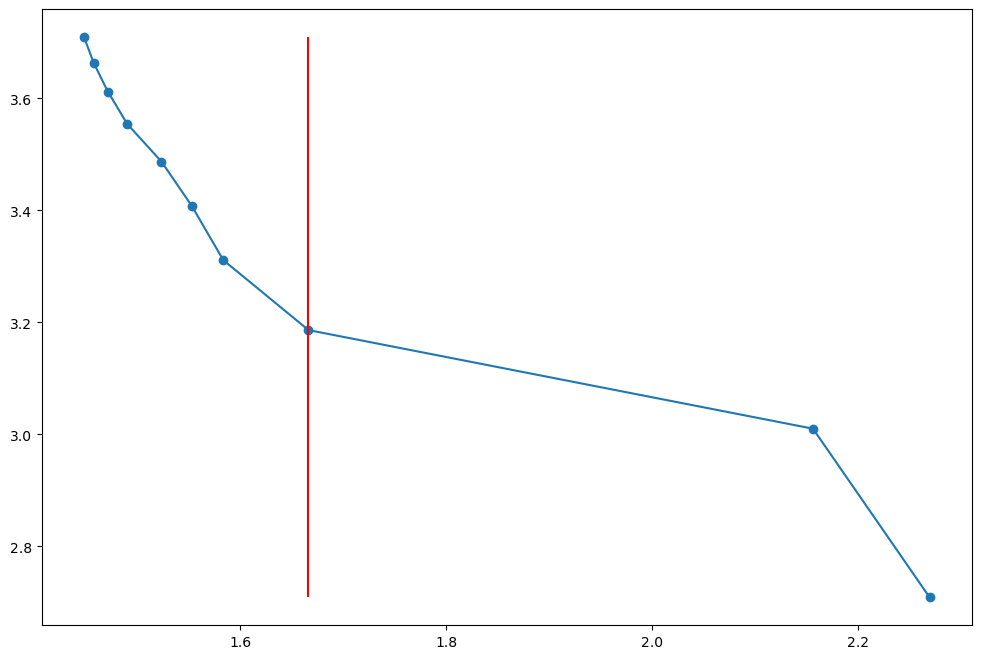

In [20]:
log_errors = []
log_coms = []
for candidate in candidates:
    com = 0
    rss = 0
    for j in range(len(Ut_grouped)):
        est_xi = SkLinearRegression(fit_intercept=False).fit(Theta_grouped[j][:, candidate[j]], Ut_grouped[j]).coef_.reshape(-1, 1)
        difference = Ut_grouped[j] - Theta_grouped[j][:, candidate[j]].dot(est_xi)
        rss += np.sum(difference**2)
        com += np.count_nonzero(est_xi)
    log_error = np.log10(np.sqrt(rss))
    log_com = np.log10(com)
    log_errors.append(log_error)
    log_coms.append(log_com)
plt.plot(log_errors, log_coms, '-o')
plt.vlines(find_corner(log_errors, log_coms, interp_method='polynomial', polynomial_degree=2), 
           ymin=min(log_coms), ymax=max(log_coms), color='red')
plt.show()